# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

References:
* https://www.youtube.com/watch?v=FgakZw6K1QQ
* https://www.youtube.com/watch?v=oRvgq966yZg
* https://www.youtube.com/watch?v=Lsue2gEM9D0
* https://www.youtube.com/watch?v=qMTuMa86NzU

       Fraction of Total Variance
PC 1                     0.164043
PC 2                     0.297278
PC 3                     0.399013
PC 4                     0.469646
PC 5                     0.508313
PC 6                     0.545121
PC 7                     0.576403
PC 8                     0.603740
PC 9                     0.629905
PC 10                    0.652214
PC 11                    0.672694
PC 12                    0.691379
PC 13                    0.708502
PC 14                    0.725531
PC 15                    0.740602
PC 16                    0.755500
PC 17                    0.770002
PC 18                    0.784195
PC 19                    0.797450
PC 20                    0.808866
PC 21                    0.819617
PC 22                    0.830251
PC 23                    0.840691
PC 24                    0.850563
PC 25                    0.859693
PC 26                    0.868231
PC 27                    0.876355
PC 28                    0.884016
PC 29         

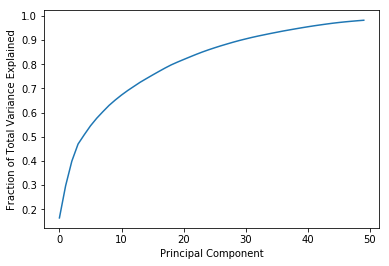

In [4]:
def P1():
### STUDENT START ###

    total_var = []

    for k in range(1, 51):
        pca = PCA(n_components=k)
        pca_data = pca.fit_transform(train_data)
        # calculate total percentage variance that each principal component accounts for
        total_var.append(np.sum(pca.explained_variance_ratio_))
    
    # display table that shows fraction of total variance explained by first k principal components
    print(pd.DataFrame(total_var,
                       columns=['Fraction of Total Variance'],
                       index=['PC ' + str(x) for x in range(1, len(total_var)+1)]))
    # plot the table
    plt.plot(total_var)
    plt.xlabel('Principal Component')
    plt.ylabel('Fraction of Total Variance Explained')
    plt.show()

    
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

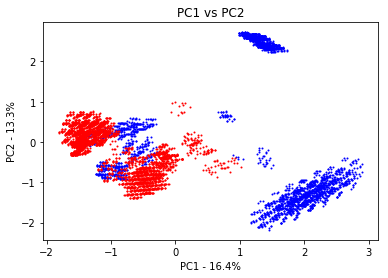

In [5]:
def P2(pca_n_components=2):
### STUDENT START ###
    
    pca = PCA(n_components=pca_n_components)
    pca_data = pca.fit_transform(train_data)  

    # create labels for each component
    labels = ['PC' + str(x) for x in range(1, pca_n_components+1)]
    # define the x, y points with x == PC1, y == PC2
    xypts = pd.DataFrame(pca_data, columns=labels)

    # calculate percentage variance that each principal component accounts for
    per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
    
    # plot PC1 vs PC2
    # 1. plot poisonous cases
    plt.scatter(xypts.PC1[train_labels == 1], xypts.PC2[train_labels == 1], c='b', s=1, marker='o')
    # 2. plot non-poisonous cases
    plt.scatter(xypts.PC1[train_labels == 0], xypts.PC2[train_labels == 0], c='r', s=1, marker='o')
    plt.title('PC1 vs PC2')
    plt.xlabel('PC1 - {}%'.format(per_var[0]))
    plt.ylabel('PC2 - {}%'.format(per_var[1]))
    plt.show()

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

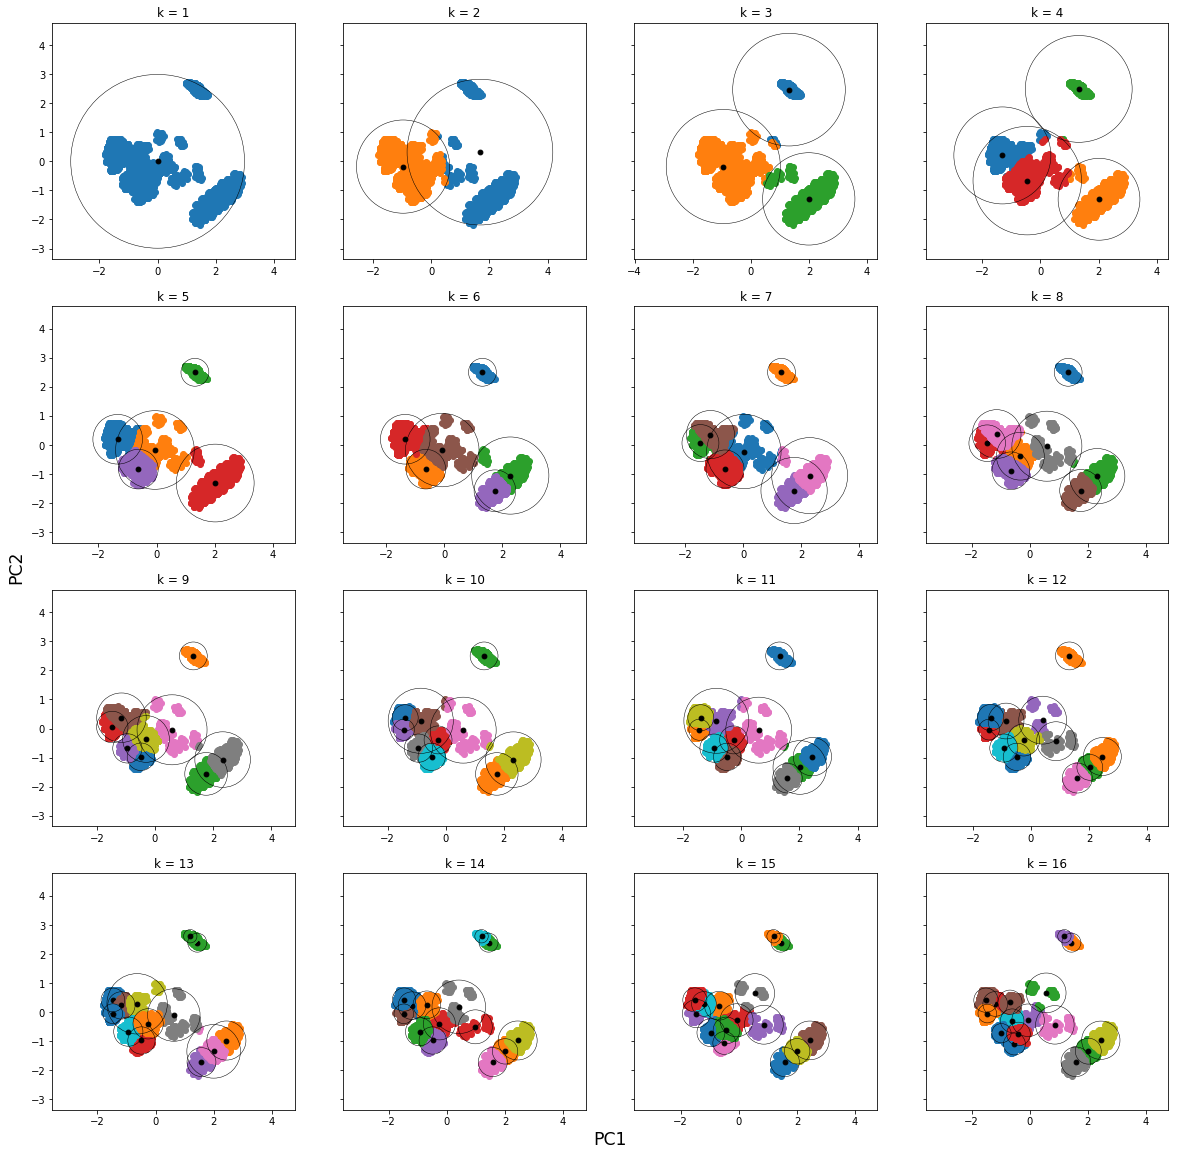

In [6]:
from math import ceil

def P3(pca_n_components=2, min_cluster=1, max_cluster=16):
### STUDENT START ###

    pca = PCA(n_components=pca_n_components)
    pca_data = pca.fit_transform(train_data)
    
    # create labels for each component
    labels = ['PC' + str(x) for x in range(1, pca_n_components+1)]
    # define the x,y points with x == PC1, y == PC2
    xypts = pd.DataFrame(pca_data, columns=labels)
    
    # define nrow x ncol plots    
    ncol = 4
    nrow = ceil(max_cluster / ncol)  
    fig, axes = plt.subplots(nrow, ncol, sharey=True, figsize=(20,20))
    
    # define the outer axes to plot x,y axis labels
    fig.add_subplot(111, frameon=False) 
    
    # define counter to specify current plot
    current_row = current_col = 0
    
    # iterate through the k-means cluster over the projected data
    for k in range(min_cluster, max_cluster+1):
        kmeans = KMeans(n_clusters=k)
        kmeans_data = kmeans.fit_transform(pca_data)
        kmeans_clusters = kmeans.labels_
        # define how far each x,y point from the centroid cluster 
        distances = pd.DataFrame(kmeans_data)
                
        # draw each cluster
        for current_cluster in set(kmeans_clusters):
            # define x,y axis to be the same size
            # otherwise, it will draw the circle as an oval
            axes[current_row, current_col].axis('equal')
            # plot the cluster
            # x-axis: PC1, y-axis: PC2
            axes[current_row, current_col].scatter(xypts['PC1'][kmeans_clusters == current_cluster], xypts['PC2'][kmeans_clusters == current_cluster])                    
            # mark the centroid cluster 
            x_centroid,  y_centroid = kmeans.cluster_centers_[current_cluster]
            axes[current_row, current_col].scatter(x_centroid, y_centroid, c='k', s=23) 
            # draw the cluster circle with the farthest distance from the centroid as radius
            circle = plt.Circle((x_centroid, y_centroid), np.max(distances[current_cluster][kmeans_clusters == current_cluster]), 
                                fill=False, linestyle='solid', linewidth=0.5)
            axes[current_row, current_col].add_patch(circle)
            # put the title
            axes[current_row, current_col].set_title('k = {}'.format(k))
            
        # go to next graph using row and column index
        if (current_col + 1) % 4 == 0:
            current_row = current_row + 1
            current_col = 0
        else:
            current_col = current_col + 1
            
    # put x,y axis labels on all plots
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.xlabel('PC1', fontsize='xx-large')
    plt.ylabel('PC2', fontsize='xx-large')
    
### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

* spherical: diagonal sitution with circular contours
* diag: contour axes are oriented along the coordinate axes, but otherwise the eccentricities may vary between components
* tied: components have the same shape, but the shape can be anything
* full: components may independently adopt any position and shape

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


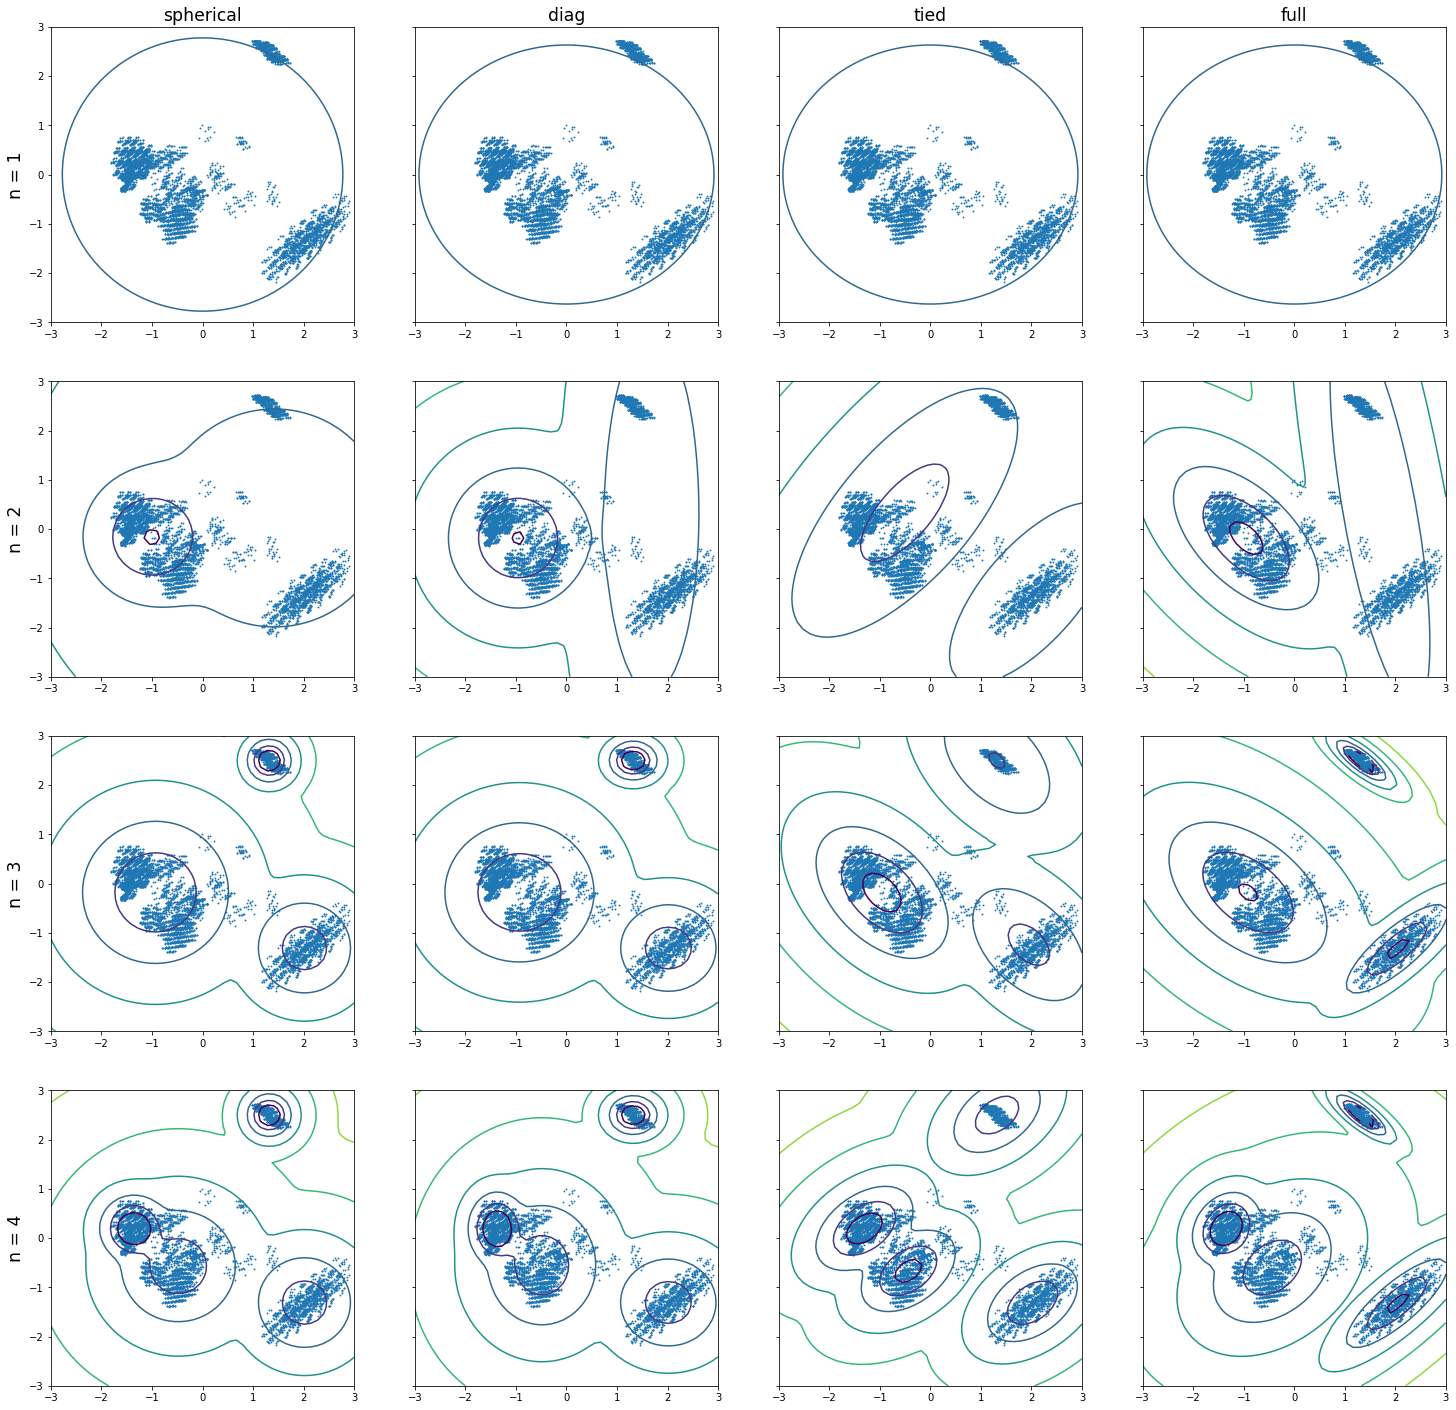

In [56]:
def P4(pca_n_components=2):
### STUDENT START ###

    pca = PCA(n_components=pca_n_components)
    pca_data = pca.fit_transform(train_data)
    
    # create labels for each component
    labels = ['PC' + str(x) for x in range(1, pca_n_components+1)]
    # define the x,y points with x == PC1, y == PC2
    xypts = pd.DataFrame(pca_data, columns=labels)
        
    # define 4x4 plots 
    # row: number of mixture components: 1, 2, 3, 4
    # col: different covariance matrix types: spherical, diag, tied, full
    num_mix_comp = list(range(1,5))
    cov_matrix_types = ['spherical', 'diag', 'tied', 'full']
    fig, axes = plt.subplots(len(num_mix_comp), len(cov_matrix_types), sharey=True, figsize=(25,25))
        
    # put row labels
    for ax, row_label in zip(axes[:,0], num_mix_comp):
        ax.set_ylabel('n = {}'.format(row_label), rotation=90, fontsize='xx-large')      

    # put col labels
    for ax, col_label in zip(axes[0], cov_matrix_types):
        ax.set_title(col_label, fontsize='xx-large')
    
    for current_row, n_components in enumerate(num_mix_comp):
        for current_col, covariance_type in enumerate(cov_matrix_types):
            # fit a Gaussian Mixture Model
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
            gmm.fit(pca_data)          
            # plot the estimated density contours
            # http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py.
            X, Y = np.meshgrid(np.linspace(-3, 3), np.linspace(-3, 3))
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)
            CS = axes[current_row][current_col].contour(X, Y, Z, 
                                                        norm=LogNorm(vmin=1, vmax=100),
                                                        levels=np.logspace(0, 3, 10)) 
            # plot the cluster
            # x-axis: PC1, y-axis: PC2
            axes[current_row, current_col].scatter(xypts['PC1'], xypts['PC2'], s=0.8)    

### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

References:

* https://plot.ly/scikit-learn/plot-gmm-covariances/

In [102]:
def P5(pca_n_components=2, gmm_n_components=4, gmm_covariance_type='full'):
### STUDENT START ###

    pca = PCA(n_components=pca_n_components)
    pca_fit = pca.fit(train_data)
    pca_train_data = pca.transform(train_data)
    pca_test_data = pca.transform(test_data)
    
    # fit 4-component full covariance GMM for positive examples (poisonous)
    pca_train_data_pos = pca_train_data[train_labels == 1]
    gmm_pos = GaussianMixture(n_components=gmm_n_components, covariance_type=gmm_covariance_type)
    gmm_pos.fit(pca_train_data_pos)
            
    # fit 4-component full covariance GMM for negative examples (non-poisonous)
    pca_train_data_neg = pca_train_data[train_labels == 0]
    gmm_neg = GaussianMixture(n_components=gmm_n_components, covariance_type=gmm_covariance_type)
    gmm_neg.fit(pca_train_data_neg)
    
    # compute the weighted log probabilities for each observation in the test dataset
    log_prob_pos = gmm_pos.score_samples(pca_test_data) # predicted log probability with positive classifier
    log_prob_neg = gmm_neg.score_samples(pca_test_data) # predicted log probability with negative classifier
    
    # predict whether the mushroom is poisonous if the probability predicted by the positive classifier 
    # was greater than the probability predicted by the negative classifier 
    pred_labels = np.array(log_prob_pos > log_prob_neg).astype(int)

    # print out the accuracy     
    return np.round(np.mean(pred_labels == test_labels), 4)
    
### STUDENT END ###

P5()

0.9368

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

Reference: 
* http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
* http://scikit-learn.org/stable/modules/mixture.html#gmm
* https://www.coursera.org/lecture/machine-learning/principal-component-analysis-algorithm-ZYIPa

In [97]:
# run example where PCA's n_components = 3, GMM's n_components = 2

# spherical
pca = PCA(n_components=3)
pca_data = pca.fit_transform(train_data)
gmm = GaussianMixture(n_components=2, covariance_type='spherical')
gmm.fit(pca_data)
gmm.covariances_

array([0.11342385, 1.225458  ])

In [98]:
# diag
pca = PCA(n_components=3)
pca_data = pca.fit_transform(train_data)
gmm = GaussianMixture(n_components=2, covariance_type='diag')
gmm.fit(pca_data)
gmm.covariances_

array([[0.23104131, 3.53103227, 0.3703156 ],
       [0.25794614, 0.27585341, 1.57516262]])

In [99]:
# full
pca = PCA(n_components=3)
pca_data = pca.fit_transform(train_data)
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(pca_data)
gmm.covariances_

array([[[ 0.02341408, -0.01576659, -0.01664322],
        [-0.01576659,  0.01629175,  0.00947022],
        [-0.01664322,  0.00947022,  0.09054612]],

       [[ 1.82761346, -0.68980034, -0.10680985],
        [-0.68980034,  0.47052108, -0.20955338],
        [-0.10680985, -0.20955338,  1.31376985]]])

In [100]:
# tied
pca = PCA(n_components=3)
pca_data = pca.fit_transform(train_data)
gmm = GaussianMixture(n_components=2, covariance_type='tied')
gmm.fit(pca_data)
gmm.covariances_

array([[ 0.84803084,  0.66074851,  0.32372631],
       [ 0.66074851,  1.08519887, -0.21037224],
       [ 0.32372631, -0.21037224,  1.05342678]])

In [103]:
def P6(max_params=50):
### STUDENT START ###

    def get_num_params(pca_n_components, gmm_n_components, gmm_covariance_type, num_classes=2):
        # number of mean vectors == number of PCA components
        num_mean_vec = pca_n_components        
        # number of covariance matrix
        num_cov_mat = 0
        # number of nonzero values in covariance matrix
        num_nz = 1

        if gmm_covariance_type == 'tied':
            # number of covariance matrix is always 1
            # can be combined with other covariance type 
            num_cov_mat = 1
        else:
            # for spherical, diagonal, and full
            num_cov_mat = pca_n_components

        if gmm_covariance_type == 'spherical':
            # least number of params && therefore fast
            # circular shape
            num_nz = 1
        elif gmm_covariance_type == 'diag':
            # middle road for the number of params 
            # oblong shape
            num_nz = 1 * pca_n_components
        elif gmm_covariance_type == 'full':
            # most number of params && therefore better precision
            # any shape
            num_nz = pca_n_components * pca_n_components

        # possible outputs:
        # ie. 3 pca_n_components, 2 gmm_n_components
        # 1. spherical, not tied: 24 = ((3 mean vector + (3 covariance matrix * 1 nonzero values)) * 2 GMM components) * 2 classes
        # 2. spherical, tied:     16 = ((3 mean vector + (1 covariance matrix * 1 nonzero values)) * 2 GMM components) * 2 classes
        # 3. diagonal, not tied:  48 = ((3 mean vector + (3 covariance matrix * 3 nonzero values)) * 2 GMM components) * 2 classes
        # 4. diagonal, tied:      24 = ((3 mean vector + (1 covariance matrix * 3 nonzero values)) * 2 GMM components) * 2 classes
        # 5. full, not tied:     120 = ((3 mean vector + (3 covariance matrix * 9 nonzero values)) * 2 GMM components) * 2 classes
        # 6. full, tied:          48 = ((3 mean vector + (1 covariance matrix * 9 nonzero values)) * 2 GMM components) * 2 classes
        return ((num_mean_vec + num_cov_mat * num_nz) * gmm_n_components) * num_classes

    # define the output variables to print out
    output_columns = ['PCA n_components', 
                      'GMM n_components', 
                      'GMM covariance_type', 
                      'num_params',
                      'accuracy']
    output = pd.DataFrame(columns=output_columns)
    
    # define the index of the output that will increment as a new row is added
    i = 0
    
    for pca_n_components in range(1, int(max_params/2)):
        for gmm_n_components in range(1, int(max_params/2)):
            # purposely not specifying tied because unsure how to compute its param numbers
            for gmm_covariance_type in ['spherical', 'diag', 'full']: 
                num_params = get_num_params(pca_n_components, gmm_n_components, gmm_covariance_type)
                if num_params <= max_params: 
                    accuracy = P5(pca_n_components, gmm_n_components, gmm_covariance_type)
                    output.loc[i] = [pca_n_components,
                                     gmm_n_components,
                                     gmm_covariance_type,
                                     num_params,
                                     accuracy]
                    i = i + 1
    
    # print the first 10 output in descending order by highest accuracy
    print(output.sort_values(by=['accuracy'], ascending=False)[:11])
    
### STUDENT END ###

P6()

   PCA n_components GMM n_components GMM covariance_type num_params  accuracy
53                3                4           spherical         48    0.9591
42                2                3           spherical         24    0.9457
44                2                4           spherical         32    0.9440
45                2                4                diag         48    0.9395
47                2                6           spherical         48    0.9368
43                2                3                diag         36    0.9359
46                2                5           spherical         40    0.9342
9                 1                4           spherical         16    0.9164
10                1                4                diag         16    0.9164
11                1                4                full         16    0.9164
27                1               10           spherical         40    0.9155
